In [7]:
import json, pickle, os, datetime, requests
import pandas as pd

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# general timeframes

In [20]:
q = '''select 
            date_trunc('quarter', date) as quarter,
            count(id), 
            median(amount)
        from transactions
        where 
            status='A' and 
            recurring=0 and
            date_part('year', date) >= 2019
        group by date'''
date_amounts = redshift_query_read(q, schema='production')

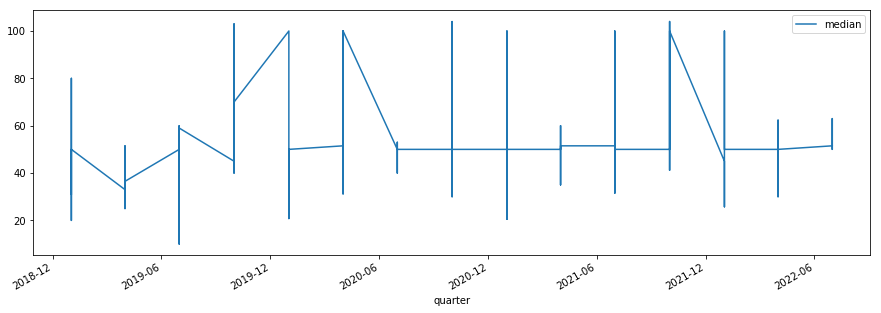

In [21]:
date_amounts.plot(x='quarter', y='median', figsize=(15,5))

In [61]:
q = '''select 
            date_trunc('month', date) as month,
            count(id), 
            median(amount)
        from transactions
        where 
            status='A' and 
            recurring=0 and
            date_part('year', date) >= 2016
        group by date'''
date_amounts = redshift_query_read(q, schema='production')

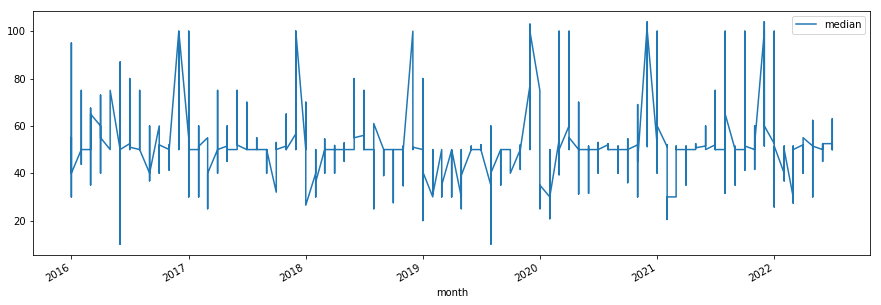

In [62]:
date_amounts.plot(x='month', y='median', figsize=(15,5))

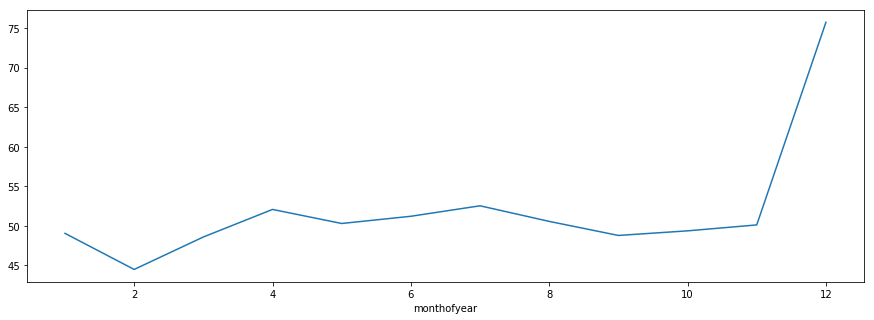

In [66]:
date_amounts['monthofyear'] = date_amounts['month'].dt.month
date_amounts.groupby('monthofyear')['median'].mean().plot(x='monthofyear', y='median', figsize=(15,5))

In [17]:
q = '''select 
            date_trunc('week', date) as week,
            count(id), 
            median(amount)
        from transactions
        where 
            status='A' and 
            recurring=0 and
            date_part('year', date) >= 2019
        group by date'''
date_amounts = redshift_query_read(q, schema='production')

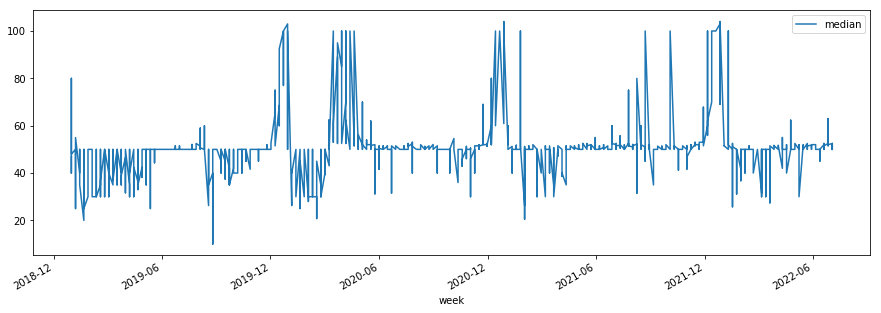

In [19]:
date_amounts.plot(x='week', y='median', figsize=(15,5))

# specific dates

- giving tuesday (2015-12-01, 2016-11-29, 2017-11-28, 2018-11-27, 2019-12-03, 2020-12-01, 2021-11-30)
- giving tuesday now (2020-05-05)
- christmas (XXXX-12-25)
- new years (XXXX-12-30, XXXX-12-31)

In [28]:
q = '''select 
            date,
            count(id), 
            median(amount)
        from transactions
        where 
            status='A' and 
            recurring=0 and
            date_part('year', date) >= 2015
        group by date'''
date_amounts = redshift_query_read(q, schema='production')

In [57]:
def is_givingtuesday(d):
    if d.year == 2015 and d.month == 12 and d.day == 1:
        return True
    elif d.year == 2021 and d.month == 11 and d.day == 30:
        return True
    elif d.year == 2020 and d.month == 12 and d.day == 1:
        return True
    elif d.year == 2019 and d.month == 12 and d.day == 3:
        return True
    elif d.year == 2018 and d.month == 11 and d.day == 27:
        return True
    elif d.year == 2017 and d.month == 11 and d.day == 28:
        return True
    elif d.year == 2016 and d.month == 11 and d.day == 29:
        return True
    return False

date_amounts['is_christmas'] = (date_amounts['date'].dt.month==12)&(date_amounts['date'].dt.day==25)
date_amounts['is_newyears'] = (date_amounts['date'].dt.month==12)&(date_amounts['date'].dt.day.isin([30, 31]))
date_amounts['is_givingtuesday'] = date_amounts['date'].apply(is_givingtuesday)
date_amounts['is_givingtuesdaynow'] = (date_amounts['date']=='2020-05-05')
date_amounts['is_endofyear'] = (date_amounts['date'].dt.month==12)&(date_amounts['date'].dt.day.isin([24, 25, 26, 27, 28, 29, 30, 31]))
date_amounts['is_payday'] = date_amounts['date'].dt.day.isin([30, 31, 1, 15])

In [58]:
for d in ['is_endofyear', 'is_christmas', 'is_newyears', 
          'is_givingtuesday', 'is_givingtuesdaynow', 
          'is_payday']:
    print(d)
    print("\t{} instances".format(len(date_amounts[date_amounts[d]])))
    print("\t${:,.2f} median amount".format(date_amounts[date_amounts[d]]['median'].mean()))
    
print("all")
print("\t${:,.2f} median amount".format(date_amounts['median'].mean()))

is_endofyear
	56 instances
	$96.30 median amount
is_christmas
	7 instances
	$79.14 median amount
is_newyears
	14 instances
	$101.28 median amount
is_givingtuesday
	7 instances
	$51.79 median amount
is_givingtuesdaynow
	1 instances
	$52.50 median amount
is_payday
	316 instances
	$56.68 median amount
all
	$52.81 median amount


__The only meaningful differences in median giving amount for specific dates/events relates to the end of the year__

# regional & device sample sizes

looking at year end (Christmas and New Year's Eve) sample sizes for device, zip codes and states.

In [73]:
q = '''select
            id,
            date,
            zip,
            state,
            amount,
            useragent
        from transactions
        where
            status='A' and
            recurring=0 and
            date_part('year', date) >= 2015 and
            date_part('month', date) = 12 and
            date_part('day', date) >= 25'''
trans = redshift_query_read(q, schema='production')

trans['is_christmas'] = (trans['date'].dt.month==12)&(trans['date'].dt.day==25)
trans['is_newyears'] = (trans['date'].dt.month==12)&(trans['date'].dt.day.isin([30, 31]))

### sample size by state

In [74]:
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 
    'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 
    'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 
    'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 
    'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 
    'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

In [80]:
def state_fix(s):
    state_truncs = {'geor': 'GA', 'ohio': 'OH', 'cali': 'CA', 'fla': 'FL',
                    'flor': 'FL', 'hawa': 'HI', 'virg': 'VA', 'texa': 'TX',
                    'newy': 'NY', 'mich': 'MI', 'arka': 'AR', 'mass': 'MA',
                    'okla': 'OK', 'idah': 'ID', 'loui': 'LA', 'illi': 'IL',
                    'conn': 'CT', 'alas': 'AK', 'colo': 'CO', 'iowa': 'IA',
                    'kans': 'KS', 'wyom': 'WY', 'wisc': 'WI', 'wash': 'WA',
                    'verm': 'VT', 'utah': 'UT', 'tenn': 'TN', 'rhod': 'RI',
                    'oreg': 'OR', 'neva': 'NV', 'nebr': 'NE', 'indi': 'IN',
                    'mont': 'MT', 'alab': 'AL', 'miss': 'MS', 'penn': 'PA',
                    'dela': 'DE'}
    if str(s).lower() in state_truncs.keys():
        return state_truncs[str(s).lower()]
    
    return str(s).upper()

trans['state'] = trans['state'].apply(state_fix)
trans = trans[trans['state'].isin(us_states)]

In [89]:
state_counts = trans.groupby(['is_christmas', 'is_newyears', 'state'])['id'].count().reset_index()
state_counts_pvt = state_counts.pivot(index='state', columns=['is_christmas', 'is_newyears'], values='id').reset_index()

In [90]:
state_counts_pvt.columns = ['state', 'neither', 'is_newyears', 'is_christmas']
state_counts_pvt

,state,neither,is_newyears,is_christmas
0,AK,101,147,4
1,AL,1120,1479,113
2,AR,273,348,30
3,AZ,3199,4400,259
4,CA,11301,17011,1319
5,CO,4050,5813,338
6,CT,1218,1887,92
7,DC,23,41,2
8,DE,701,1236,62
9,FL,7349,8156,949


### sample size by device

In [96]:
def tag_platform(u):
    u = str(u)
    if 'iPhone' in u:
        return 'iPhone'
    elif 'iPad' in u:
        return 'iPad'
    elif 'Android' in u:
        return 'Android'
    elif 'IntelMacOSX' in u:
        return 'Mac'
    elif 'Windows' in u:
        return 'Windows'
    else:
        return u

platforms = ['iPhone', 'iPad', 'Android', 'Mac', 'Windows']
trans['platform'] = trans['useragent'].apply(tag_platform)
trans = trans[trans['platform'].isin(platforms)]

In [97]:
platform_counts = trans.groupby(['is_christmas', 'is_newyears', 'platform'])['id'].count().reset_index()
platform_counts_pvt = platform_counts.pivot(index='platform', columns=['is_christmas', 'is_newyears'], values='id').reset_index()

In [98]:
platform_counts_pvt.columns = ['platform', 'neither', 'is_newyears', 'is_christmas']

In [99]:
platform_counts_pvt

,platform,neither,is_newyears,is_christmas
0,Android,5080,6908,940
1,Mac,22067,33959,2226
2,Windows,50763,69239,4054
3,iPad,3243,5167,328
4,iPhone,9586,15039,1695


# data build

build the full data set and look at true sample sizes

In [100]:
q = '''select
            id,
            date,
            zip,
            state,
            amount,
            useragent
        from transactions
        where
            status='A' and
            recurring=0 and
            date_part('year', date) >= 2015 and
            date_part('month', date) = 12 and
            date_part('day', date) >= 25'''
trans = redshift_query_read(q, schema='production')

# tag Christmas and NYE
trans['is_christmas'] = (trans['date'].dt.month==12)&(trans['date'].dt.day==25)
trans['is_newyears'] = (trans['date'].dt.month==12)&(trans['date'].dt.day.isin([30, 31]))

In [101]:
# tag platform
trans['platform'] = trans['useragent'].apply(tag_platform)
trans = trans[trans['platform'].isin(platforms)]

In [102]:
# tag state
trans['state'] = trans['state'].apply(state_fix)
trans = trans[trans['state'].isin(us_states)]

In [107]:
trans_grp = trans.groupby(['zip', 'state', 'platform', 'is_christmas', 'is_newyears'])['amount'].agg(['median', 'count']).reset_index()

In [113]:
print("Zip code/platform/events sample sizes")
trans_grp['count'].value_counts().head(25)

Zip code/platform/events sample sizes


1     41000
2     11815
3      5912
4      3418
5      2260
6      1678
7      1247
8       907
9       736
10      613
11      457
12      420
13      334
14      271
15      267
17      216
16      209
19      174
18      172
21      128
20      125
22       91
23       83
26       78
25       76
Name: count, dtype: int64

In [114]:
trans_grp = trans.groupby(['state', 'platform', 'is_christmas', 'is_newyears'])['amount'].agg(['median', 'count']).reset_index()
print("State/platform/events sample sizes")
trans_grp['count'].value_counts().head(25)

State/platform/events sample sizes


3     19
6     17
1     17
2     17
11    16
5     15
8     13
4     11
16    10
10     9
7      9
9      9
17     8
20     8
13     8
26     8
29     7
12     7
14     7
18     6
22     6
40     6
32     6
23     6
25     6
Name: count, dtype: int64